Hunter Bennett | Glass Lab | Kupffer Strains Project | May 03 2021  

This notebook is for making fancier figure level plots describing differential gene expression for the strains NASH paper. It generates the following plots:
1. Clustered heatmap of differential peaks

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib_venn import venn2
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 500

# clustering packages
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [3]:
atacDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/10_Strains_Manuscript_Prep/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for "fancy figures" for manuscript

In [4]:
if not os.path.isdir('./h3k27ac_atac_correlation/'):
    os.mkdir('./h3k27ac_atac_correlation/')

### Import differential peaks

In [5]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    h3k27acDirectory+'/merged_peaks/diff_output.txt',
    h3k27acDirectory+'/merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (86301, 27)
getDiffExpression selected transcripts (84264, 36)
annotatePeaks selected peaks (84264, 27)


In [6]:
diff_peak_atac, peaks_atac, peak_mat_atac, peak_mat_quant_atac = import_homer_diffpeak(
    atacDirectory+'/merged_peaks/diff_output.txt',
    atacDirectory+'/merged_peaks/ann_norm_idr_peaks_merged.txt')

annotatePeaks all peaks (86301, 30)
getDiffExpression selected transcripts (84264, 39)
annotatePeaks selected peaks (84264, 30)


In [7]:
greps = ['aj.*ATAC',
         'balbc.*ATAC',
         'c57bl6j.*ATAC',
         'aj.*H3K27',
         'balb.*H3K27',
         '57.*H3K27']

colnames = ['aj_atac_average',
            'balbcj_atac_average',
            'c57bl6j_atac_average',
            'aj_h3k27ac_average',
            'balbcj_h3k27ac_average',
            'c57bl6j_h3k27ac_average']

## Extract average atac and h3k27ac tags

In [8]:
avg_tags_atac_dict = {}
for colname, grep in zip(colnames[:3], greps[:3]):
    avg_tags_atac_dict[colname] = peak_mat_atac.loc[:, peak_mat_atac.columns.str.contains(grep)].mean(1)
    
avg_tags_atac_df = pd.DataFrame(avg_tags_atac_dict)

In [9]:
avg_tags_h3k27ac_dict = {}
for colname, grep in zip(colnames[3:], greps[3:]):
    avg_tags_h3k27ac_dict[colname] = peak_mat.loc[:, peak_mat.columns.str.contains(grep)].mean(1)
    
avg_tags_h3k27ac_df = pd.DataFrame(avg_tags_h3k27ac_dict)

In [10]:
avg_tags_df = avg_tags_atac_df.merge(avg_tags_h3k27ac_df, left_index=True, right_index=True)

In [11]:
color_dict = {'aj': ('#de2d26', '#a50f15'),
              'balbcj': ('#3182bd', '#08519c'),
              'c57bl6j': ('#31a354', '#006d2c')}

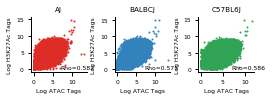

In [18]:
strains = ['aj', 'balbcj', 'c57bl6j']

fig, axs = plt.subplots(1, 3, figsize=(4,1))
plt.subplots_adjust(wspace=0.5)

for ax, strain in zip(axs, strains):
    ax.scatter(np.log2(avg_tags_df.loc[:, strain+'_atac_average']+1),
               np.log2(avg_tags_df.loc[:, strain+'_h3k27ac_average']+1),
               s=1,
               c=color_dict[strain][0],
               rasterized=True)
    
    # set title
    ax.set_title(strain.upper())
    
    # set x label and y label
    ax.set_xlabel('Log ATAC Tags')
    ax.set_ylabel('Log H3K27Ac Tags')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
    # annotate with corr
    # set axis text
    ax.text(7, 0, 'Rho=%.3f' % (avg_tags_df.corr(method='spearman').loc[
                                   strain+'_atac_average',
                                   strain+'_h3k27ac_average']) )
    

plt.savefig('./h3k27ac_atac_correlation/scatter_plot.pdf',
            bbox_inches='tight')

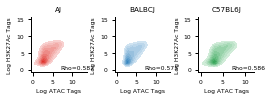

In [19]:
strains = ['aj', 'balbcj', 'c57bl6j']

fig, axs = plt.subplots(1, 3, figsize=(4,1))
plt.subplots_adjust(wspace=0.5)

for ax, strain in zip(axs, strains):
    kde = sns.kdeplot(np.log2(avg_tags_df.loc[:, strain+'_atac_average']+1),
                np.log2(avg_tags_df.loc[:, strain+'_h3k27ac_average']+1),
                # s=1,
                shade=True,
                color=color_dict[strain][0],
                ax=ax)
    
    kde.collections[0].set_alpha(0)
    
    # set title
    ax.set_title(strain.upper())
    
    # set x label and y label
    ax.set_xlabel('Log ATAC Tags')
    ax.set_ylabel('Log H3K27Ac Tags')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
    # annotate with corr
    # set axis text
    ax.text(7, 0, 'Rho=%.3f' % (avg_tags_df.corr(method='spearman').loc[
                                   strain+'_atac_average',
                                   strain+'_h3k27ac_average']) )
    

plt.savefig('./h3k27ac_atac_correlation/kde_plot.pdf',
            bbox_inches='tight')